In [10]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Embedding, ModuleList, Sequential, ReLU, Dropout, BatchNorm1d
from torch_geometric.nn import GATv2Conv, BatchNorm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph

In [11]:
load_dotenv(find_dotenv())

PROJECT_ROOT = Path(find_dotenv()).parent.resolve()
print(f"PROJECT_ROOT set to: {PROJECT_ROOT}")

DATA_DIR = PROJECT_ROOT / 'data'

PROJECT_ROOT set to: C:\Users\rtrin\OneDrive\Escritorio\FORMACIÓN\MÁSTER\TSCD\ProyectoTSCD


# Importación de datos

In [36]:
datos = pd.read_csv(DATA_DIR / 'datos.csv')
datos.set_index('ptnum', inplace=True)

Dividimos en conjuntos de entrenamiento, validación y prueba.


In [50]:
X = datos.drop(columns=['target']).to_numpy(dtype=np.float32)
y = datos['target'].to_numpy(dtype=np.int64)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_trai_nt, y_train, y_trai_nt = train_test_split(X,y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_trai_nt,y_trai_nt, test_size=0.5, random_state=42)

# Seleccion de nodos y construcción del grafo
Grafo de nodos y aristas construidas mediante el método métrico KNN

In [84]:

k = 5
adj_train = kneighbors_graph(X_train, n_neighbors=k, mode='connectivity', include_self=False,metric='euclidean')
coo = adj_train.tocoo() #Pasa la matriz de adyaciencia a listas de nodos conectados. Cada elemento de coo.row es un nodo origen y el elemento correspondiente de coo.col es el nodo destino.
edge_index_train= torch.stack([torch.tensor(coo.row), torch.tensor(coo.col)], dim=0).long()


Ahora edge_index es nuestra representación de los nodos y aristas del grafo mediante lo que se conoce como una "lista de aristas" (edge list) pero en este caso traspuesta.

# Grafo de isntancias

Lo haremos con el conjunto de validación pues son menos nodos y es más sencillo de visualizar.

In [ ]:
k = 5
adj_valid = kneighbors_graph(X_valid, n_neighbors=k, mode='connectivity', include_self=False,metric='euclidean')
coo = adj_valid.tocoo() #Pasa la matriz de adyaciencia a listas de nodos conectados. Cada elemento de coo.row es un nodo origen y el elemento correspondiente de coo.col es el nodo destino.
edge_list_valid = [(a, b) for a, b in zip(coo.row, coo.col)]

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

In [77]:
G = nx.Graph()
G.add_edges_from(edge_list_valid)

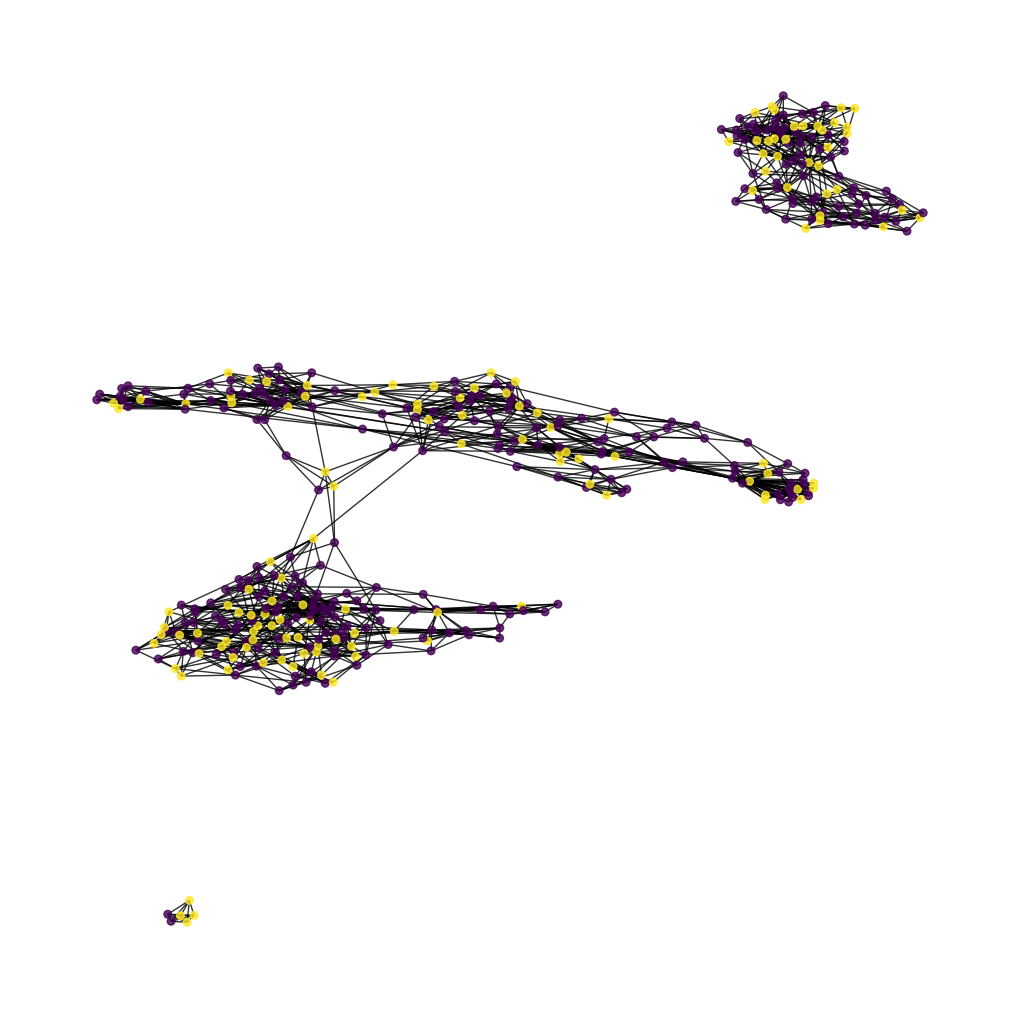

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw(G,node_size=30, node_color=y_valid, alpha=0.8)
plt.show()

# Preparamos el grafo para un modelo de aprendizaje profundo

In [85]:
from torch_geometric.utils import from_networkx
data = from_networkx(G)
edge_index_valid= data.edge_index

In [40]:
torch.manual_seed(42)
np.random.seed(42)

In [86]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(number_of_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)